In [1]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.cluster import AgglomerativeClustering

training/050.tif


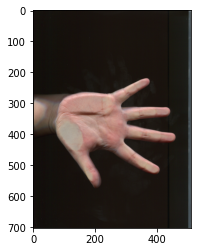

In [2]:
listing = list(os.scandir("training"))
def get_rand_im():
    a = random.sample(listing, 1)[0].path
    print(a)
    return cv.imread(a)

img = get_rand_im()
H, W, _ = img.shape
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

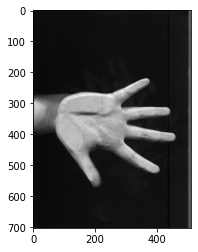

In [3]:
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap="gray");

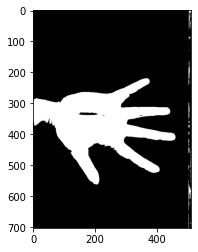

In [4]:
_, bin_img = cv.threshold(gray_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
plt.imshow(bin_img, cmap="gray");

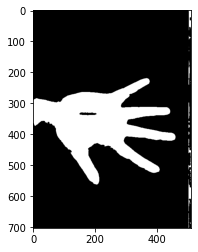

In [5]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
closed_img = cv.morphologyEx(bin_img, cv.MORPH_CLOSE, kernel)
plt.imshow(closed_img, cmap="gray");

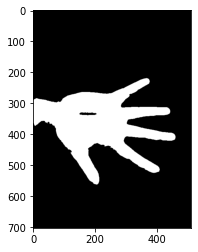

In [6]:
def segment(bin_img):
    num_labels, labeled_img = cv.connectedComponents(bin_img)
    num_items = [(labeled_img == label).sum() for label in range(num_labels)]
    def second_max(arr):
        max1, max2, ind2 = 0, 0, 0
        for i, el in enumerate(arr):
            if el > max1:
                max1 = el
            elif el > max2:
                max2, ind2 = el, i
        return ind2

    mask = (labeled_img == second_max(num_items)).astype(np.uint8)
    return cv.bitwise_and(bin_img, mask)

segmented_img = segment(closed_img)
plt.imshow(segmented_img, cmap="gray");

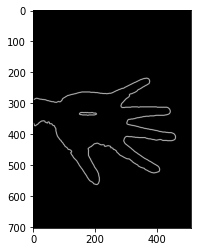

In [7]:
sobelx = cv.Sobel(segmented_img, cv.CV_64F, 1, 0, ksize=5)
sobely = cv.Sobel(segmented_img, cv.CV_64F, 0, 1, ksize=5)
edges = np.sqrt(sobelx ** 2 + sobely ** 2).astype(np.uint8)
plt.imshow(edges, cmap='gray');

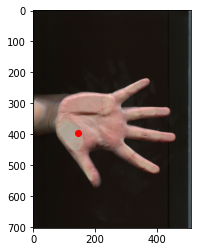

In [8]:
def find_center(edge_list, background):
    maxi = 0
    maxmin = 0, 0
    for h, w in it.product(range(H), range(W)):
        if background[h][w]:
            dist_between_cur_and_edges = np.sum((edge_list - np.array([h, w])) ** 2, axis=1)
            mini = np.min(dist_between_cur_and_edges)
            if mini > maxi:
                maxi = mini
                maxmin = h, w
    return maxmin

edge_list = np.array([[h, w] for h, w in it.product(range(H), range(W)) if edges[h, w]])
c_h, c_w = find_center(edge_list, segmented_img)
plt.scatter([c_w], [c_h], c="r")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

In [9]:
def to_polar(xy):
    y, x = xy[:, 0], xy[:, 1]
    r = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return r, phi

def to_euclidian(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return x, y

def find_local_maxs(r, edge_list_centered, local_r):
    local_maxs, candidates = [], []
    y, x = edge_list_centered[:, 0], edge_list_centered[:, 1]
    for h, w, rr in zip(y, x, r):
        if rr >= r[np.sqrt(np.sum((edge_list_centered - np.array([h, w])) ** 2, axis=1)) <
                   local_r].max():
            candidates.append([h, w])
    candidates = np.array(candidates)
    i = 0
    while i < len(candidates):
        dist_between_cur_and_mins = np.sum((candidates - candidates[i]) ** 2, axis=1)
        dist_between_cur_and_mins = dist_between_cur_and_mins[dist_between_cur_and_mins != 0]
        mini = np.min(dist_between_cur_and_mins)
        if mini > local_r:
            local_maxs.append(candidates[i])
            i += 1
        else:
            candidates = np.delete(candidates, [i], axis=0)
    return np.array(local_maxs)

def find_local_mins(r, edge_list_centered, local_r):
    candidates, local_mins = [], []
    y, x = edge_list_centered[:, 0], edge_list_centered[:, 1]
    for h, w, rr in zip(y, x, r):
        if rr <= r[np.sqrt(np.sum((edge_list_centered - np.array([h, w])) ** 2, axis=1)) <
                   local_r].min():
            candidates.append([h, w])
    candidates = np.array(candidates)
    i = 0
    while i < len(candidates):
        dist_between_cur_and_mins = np.sum((candidates - candidates[i]) ** 2, axis=1)
        dist_between_cur_and_mins = dist_between_cur_and_mins[dist_between_cur_and_mins != 0]
        mini = np.min(dist_between_cur_and_mins)
        if mini > local_r:
            local_mins.append(candidates[i])
            i += 1
        else:
            candidates = np.delete(candidates, [i], axis=0)
    return np.array(local_mins)

edge_list_centered = edge_list - np.array([c_h, c_w])
r, _ = to_polar(edge_list_centered)
local_maxs = find_local_maxs(r, edge_list_centered, 25)
local_mins = find_local_mins(r, edge_list_centered, 25)

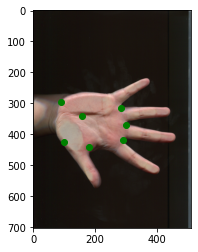

In [10]:
plt.scatter(local_mins[:, 1] + c_w, local_mins[:, 0] + c_h, c="g")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

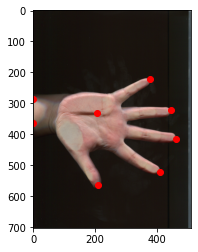

In [11]:
plt.scatter(local_maxs[:, 1] + c_w, local_maxs[:, 0] + c_h, c="r")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

In [12]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='cosine',
                                     linkage='single').fit(local_maxs)
labels = clustering.labels_

def select_cluster(xy, labels):
    y, x = xy[:, 0], xy[:, 1]
    r = np.sqrt(x ** 2 + y ** 2)
    inds = r.argsort()[::-1]
    score = [0, 0]
    for ind in inds:
        lab = labels[ind]
        score[lab] += 1
        if score[lab] == 4:
            return lab
current_cluster = select_cluster(local_maxs, labels)

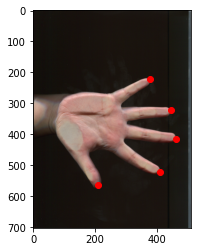

In [13]:
def normalize_cluster(xy, labels, current_cluster):
    another_cluster = 1 - current_cluster
    if (labels == current_cluster).sum() == 4:
        inds = np.arange(len(labels))
        another_inds = inds[labels != current_cluster]
        cur_vecs = xy[labels == current_cluster]
        another_vecs = xy[labels != current_cluster]
        dists = ((cur_vecs[:, np.newaxis, :] - another_vecs[np.newaxis, :, :]) ** 2 ).sum(axis=2)\
                ** 0.5
        mins = dists.min(axis=0)
        amin = mins.argmin()
        labels[another_inds[amin]] = current_cluster
    elif (labels == current_cluster).sum() > 5:
        inds = np.arange(len(labels))
        cur_inds = inds[labels == current_cluster]
        cur_vecs = xy[labels == current_cluster]
        x, y = cur_vecs[:, 0], cur_vecs[:, 1]
        r = np.sqrt(x ** 2 + y ** 2)
        sort_inds = r.argsort()[::-1]
        labels[cur_inds[sort_inds[5:]]] = another_cluster
    return labels

labels = normalize_cluster(local_maxs, labels, current_cluster)
local_maxs = local_maxs[labels == current_cluster]
plt.scatter(local_maxs[:, 1] + c_w, local_maxs[:, 0] + c_h, c="r")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

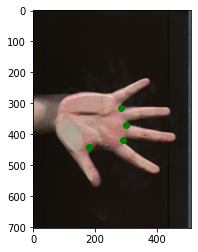

In [14]:
def select_local_mins(local_maxs, local_mins, mindist=40):
    pair_distances = []
    for cur in local_mins:
        dists = np.sum((local_maxs - cur) ** 2, axis=1) ** 0.5
        dists = np.sort(dists)
        if dists[0] < mindist:
            dists += 200
        pair_distances.append(dists[: 2].sum())
    inds = np.array(pair_distances).argsort()
    return local_mins[inds[:4]]

local_mins = select_local_mins(local_maxs, local_mins)
plt.scatter(local_mins[:, 1] + c_w, local_mins[:, 0] + c_h, c="g")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

In [15]:
def find_extreme_points(xy):
    max_angle = 0
    for i, j in it.product(range(len(xy)), range(len(xy))):
        if i != j:
            v1 = xy[i]
            v2 = xy[j]
            angle = np.arccos(np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)))
            if angle > max_angle:
                max_angle = angle
                mi = i
                mj = j
    return mi, mj

def put(xy1, xy2, ind11, ind12, ind21, ind22, put_ind1, put_ind2, l):
    if(np.linalg.norm(xy1[ind11] - xy2[ind21]) + np.linalg.norm(xy1[ind12] - xy2[ind22])
       < np.linalg.norm(xy1[ind11] - xy2[ind22]) + np.linalg.norm(xy1[ind12] - xy2[ind21])):
        l[put_ind1].append(xy1[ind11])
        l[put_ind2].append(xy1[ind12])
    else:
        l[put_ind2].append(xy1[ind11])
        l[put_ind1].append(xy1[ind12])

res = [[] for _ in local_mins]
max_ext = find_extreme_points(local_maxs)
min_ext = find_extreme_points(local_mins)
ind_set = [max_ext[0], max_ext[1]]
put(local_maxs, local_mins, max_ext[0], max_ext[1], min_ext[0], min_ext[1], min_ext[0], min_ext[1],
    res)

ind = np.arange(len(local_maxs))
another_max_xy = local_maxs[(ind != max_ext[0]) & (ind != max_ext[1])]
inds_max = ind[(ind != max_ext[0]) & (ind != max_ext[1])]
max_ext = find_extreme_points(another_max_xy)
ind_set += [inds_max[max_ext[0]], inds_max[max_ext[1]]]
put(another_max_xy, local_mins, max_ext[0], max_ext[1], min_ext[0], min_ext[1], min_ext[0],
    min_ext[1], res)

ind = np.arange(len(local_mins))
another_min_xy = local_mins[(ind != min_ext[0]) & (ind != min_ext[1])]
inds_min = ind[(ind != min_ext[0]) & (ind != min_ext[1])]
put(another_max_xy, another_min_xy, max_ext[0], max_ext[1], 0, 1, inds_min[0], inds_min[1], res)

last_max = list(set(range(5)) - set(ind_set))[0]
res[inds_min[0]].append(local_maxs[last_max])
res[inds_min[1]].append(local_maxs[last_max])

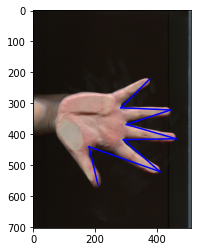

In [16]:
def clockwise(dot1, dot2, dot3):
    return (dot2[0] - dot1[0]) * (dot3[1] - dot1[1]) - (dot2[1] - dot1[1]) * (dot3[0] - dot1[0])\
           > 0

lines = []
for i in range(len(res)):
    if clockwise(res[i][0], local_mins[i], res[i][1]):
        lines.append((res[i][0], local_mins[i], res[i][1]))
    else:
        lines.append((res[i][1], local_mins[i], res[i][0]))

for l in lines:
    plt.plot([l[1][1] + c_w, l[0][1] + c_w], [l[1][0] + c_h, l[0][0] + c_h], c="blue")
    plt.plot([l[1][1] + c_w, l[2][1] + c_w], [l[1][0] + c_h, l[2][0] + c_h], c="blue")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));
